# Peptides encoding (One-hot)

In [1]:
import peptides
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from math import sqrt

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

# my module with some func
import pepcode

## Preparing data

Set parameters: 

In [2]:
AA_LIST = pepcode.AA_LIST

Load training dataset:

In [3]:
pep_train_list = []
with open("./dataset/train_cdr3.txt") as file:
    for pep in file:
        pep = pep[:-1]
        pep_train_list.append(pep)

len_seq = len(pep_train_list[0])

pep_train_oh = np.zeros((len(pep_train_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_train_list)):
    pep_train_oh[i] = pepcode.one_hot_code(pep_train_list[i])

Load evaluation dataset:

In [4]:
pep_eval_list = []
with open("./dataset/eval_cdr3.txt") as file:
    for pep in file:
        pep = pep[:-1]
        pep_eval_list.append(pep)

pep_eval_oh = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_oh[i] = pepcode.one_hot_code(pep_eval_list[i])

Load test dataset:

In [5]:
pep_test_list = []
with open("./dataset/test_cdr3.txt") as file:
    for pep in file:
        pep = pep[:-1]
        pep_test_list.append(pep)

pep_test_oh = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_oh[i] = pepcode.one_hot_code(pep_test_list[i])

## Set parameters for ml

In [6]:
latent_dims = 200
num_epochs = 500 
batch_size = int(round(len(pep_train_list)/6))
learning_rate = 1e-3 
use_gpu = True

oh_matr_size = pep_test_oh[0].size

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Loading datasets

In [7]:
# Train dataset
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_oh), torch.tensor(np.ones(pep_train_oh.shape[0])))
oh_dl_train = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=True)

# Eval dataset
oh_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_oh), torch.tensor(np.ones(pep_eval_oh.shape[0])))
oh_dl_eval = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=True)

# Test dataset
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_oh), torch.tensor(np.ones(pep_test_oh.shape[0])))
oh_dl_test = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=True)


## Autoencoder_1 definition (300->50)

In [8]:
numb = 1
autoencoder_arch = '300->50 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=50)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=50, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 30350


### Train autoencoder

In [9]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.243584
Epoch [11 / 500] average reconstruction error: 0.029241
Epoch [21 / 500] average reconstruction error: 0.026933
Epoch [31 / 500] average reconstruction error: 0.027171
Epoch [41 / 500] average reconstruction error: 0.025905
Epoch [51 / 500] average reconstruction error: 0.024692
Epoch [61 / 500] average reconstruction error: 0.023669
Epoch [71 / 500] average reconstruction error: 0.023182
Epoch [81 / 500] average reconstruction error: 0.022350
Epoch [91 / 500] average reconstruction error: 0.021451
Epoch [101 / 500] average reconstruction error: 0.019999
Epoch [111 / 500] average reconstruction error: 0.019603
Epoch [121 / 500] average reconstruction error: 0.018417
Epoch [131 / 500] average reconstruction error: 0.018970
Epoch [141 / 500] average reconstruction error: 0.017108
Epoch [151 / 500] average reconstruction error: 0.016441
Epoch [161 / 500] average reconstruction error: 0.015327
Epoch [171 / 500] average rec

### Evaluation

In [10]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.002905


### Biological evaluatiuon

In [11]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

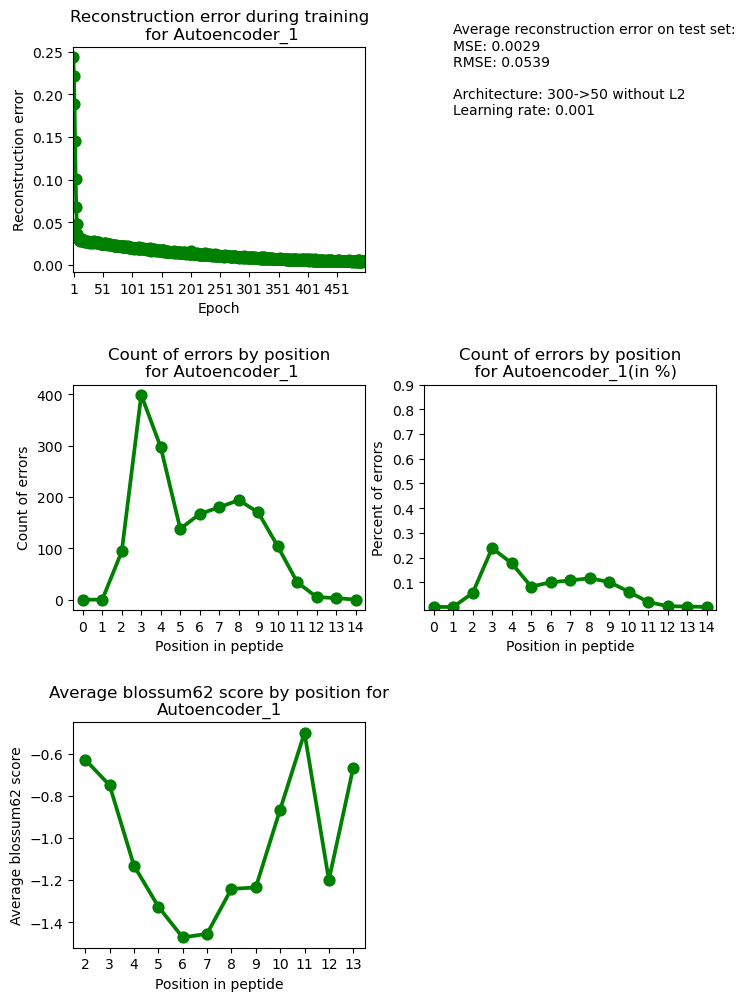

In [12]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_2 definition (300->100)

In [13]:
numb += 1
autoencoder_arch = '300->100 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 60400


### Train autoencoder

In [14]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.242960
Epoch [11 / 500] average reconstruction error: 0.027395
Epoch [21 / 500] average reconstruction error: 0.026606
Epoch [31 / 500] average reconstruction error: 0.025171
Epoch [41 / 500] average reconstruction error: 0.024682
Epoch [51 / 500] average reconstruction error: 0.022230
Epoch [61 / 500] average reconstruction error: 0.022275
Epoch [71 / 500] average reconstruction error: 0.018600
Epoch [81 / 500] average reconstruction error: 0.018071
Epoch [91 / 500] average reconstruction error: 0.017228
Epoch [101 / 500] average reconstruction error: 0.016005
Epoch [111 / 500] average reconstruction error: 0.014480
Epoch [121 / 500] average reconstruction error: 0.013958
Epoch [131 / 500] average reconstruction error: 0.014826
Epoch [141 / 500] average reconstruction error: 0.012995
Epoch [151 / 500] average reconstruction error: 0.010600
Epoch [161 / 500] average reconstruction error: 0.010196
Epoch [171 / 500] average rec

### Evaluation

In [15]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.001059


### Biological evaluatiuon

In [16]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

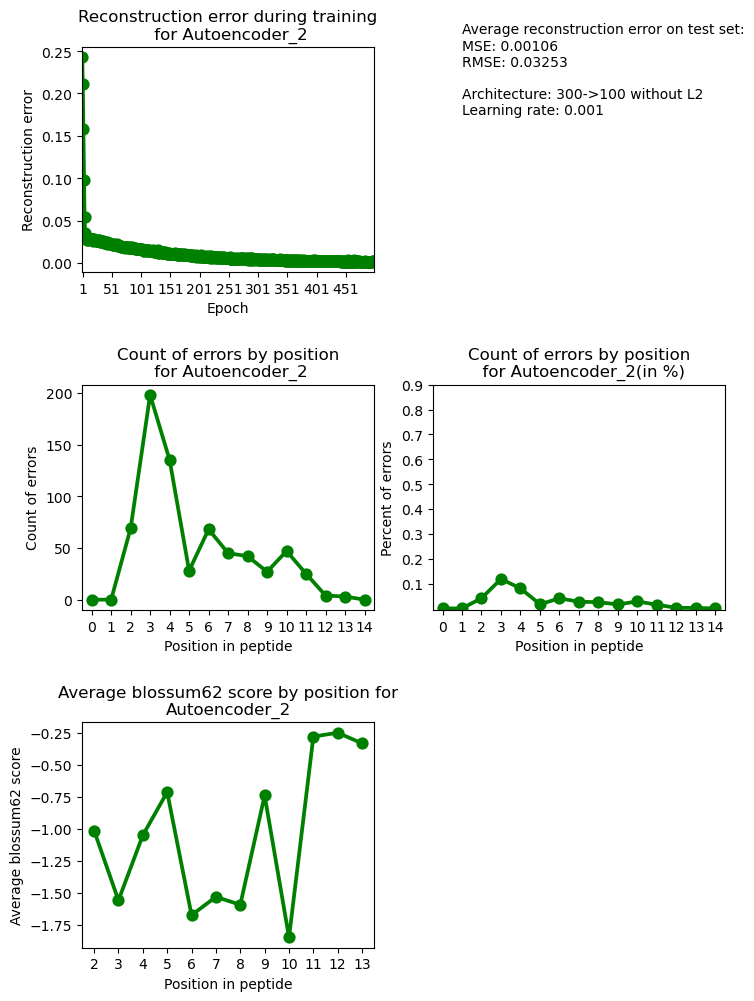

In [17]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_3 definition (300->200)

In [18]:
numb += 1
autoencoder_arch = '300->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 120500


### Train autoencoder

In [19]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.235057
Epoch [11 / 500] average reconstruction error: 0.027505
Epoch [21 / 500] average reconstruction error: 0.026439
Epoch [31 / 500] average reconstruction error: 0.023636
Epoch [41 / 500] average reconstruction error: 0.019423
Epoch [51 / 500] average reconstruction error: 0.017933
Epoch [61 / 500] average reconstruction error: 0.016104
Epoch [71 / 500] average reconstruction error: 0.014907
Epoch [81 / 500] average reconstruction error: 0.014541
Epoch [91 / 500] average reconstruction error: 0.011671
Epoch [101 / 500] average reconstruction error: 0.010796
Epoch [111 / 500] average reconstruction error: 0.010564
Epoch [121 / 500] average reconstruction error: 0.009406
Epoch [131 / 500] average reconstruction error: 0.007451
Epoch [141 / 500] average reconstruction error: 0.006333
Epoch [151 / 500] average reconstruction error: 0.006946
Epoch [161 / 500] average reconstruction error: 0.005392
Epoch [171 / 500] average rec

### Evaluation

In [20]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000311


### Biological evaluatiuon

In [21]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

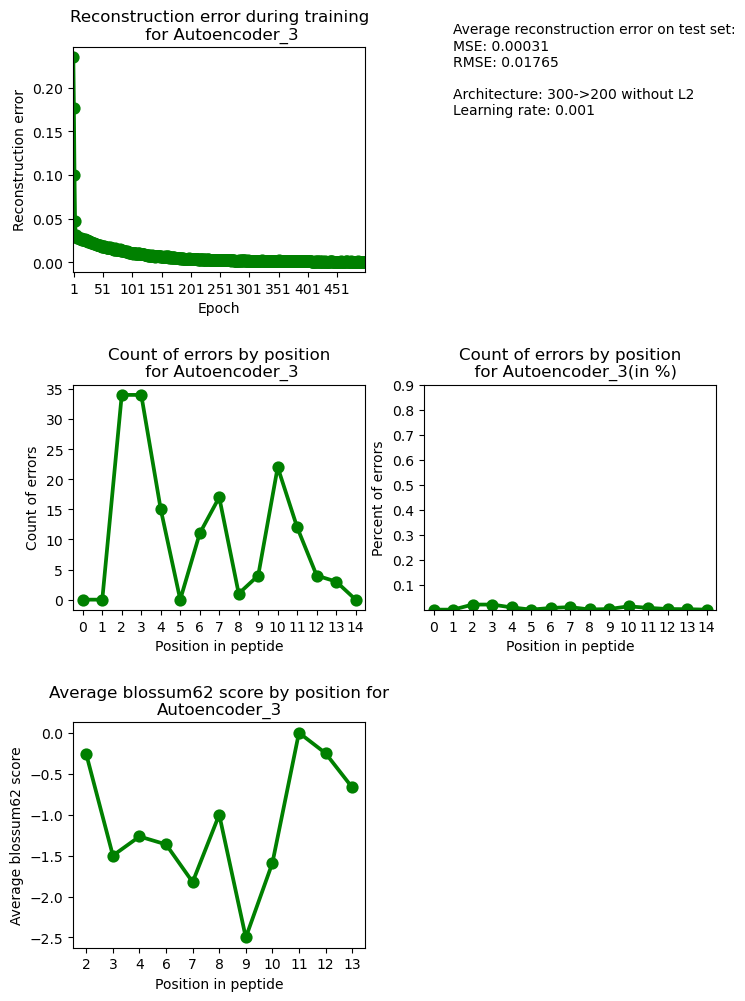

In [22]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_4 definition (300->300)

In [23]:
numb += 1
autoencoder_arch = '300->300 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=300)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=300, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 180600


### Train autoencoder

In [24]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.222654
Epoch [11 / 500] average reconstruction error: 0.027346
Epoch [21 / 500] average reconstruction error: 0.023832
Epoch [31 / 500] average reconstruction error: 0.020813
Epoch [41 / 500] average reconstruction error: 0.017344
Epoch [51 / 500] average reconstruction error: 0.014924
Epoch [61 / 500] average reconstruction error: 0.013820
Epoch [71 / 500] average reconstruction error: 0.012029
Epoch [81 / 500] average reconstruction error: 0.010395
Epoch [91 / 500] average reconstruction error: 0.009193
Epoch [101 / 500] average reconstruction error: 0.007295
Epoch [111 / 500] average reconstruction error: 0.006233
Epoch [121 / 500] average reconstruction error: 0.006121
Epoch [131 / 500] average reconstruction error: 0.005405
Epoch [141 / 500] average reconstruction error: 0.004870
Epoch [151 / 500] average reconstruction error: 0.004718
Epoch [161 / 500] average reconstruction error: 0.003305
Epoch [171 / 500] average rec

### Evaluation

In [25]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000182


### Biological evaluatiuon

In [26]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

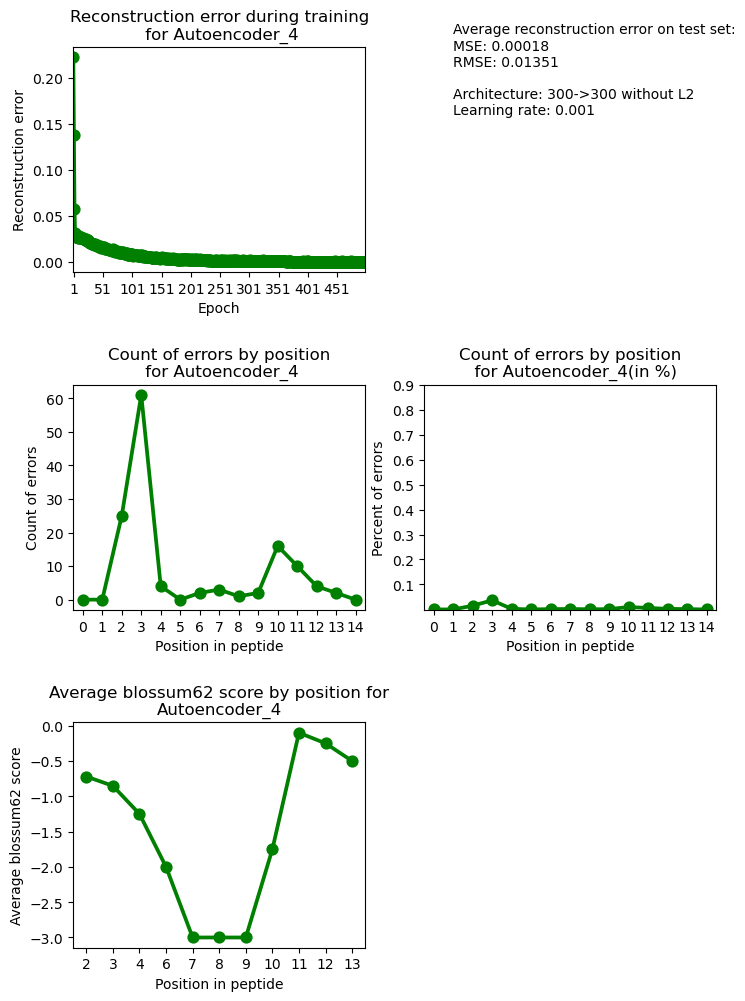

In [27]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_5 definition (300->700->200)

In [28]:
numb += 1
autoencoder_arch = '300->700->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [29]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.197571
Epoch [11 / 500] average reconstruction error: 0.035014
Epoch [21 / 500] average reconstruction error: 0.033958
Epoch [31 / 500] average reconstruction error: 0.029192
Epoch [41 / 500] average reconstruction error: 0.020431
Epoch [51 / 500] average reconstruction error: 0.016037
Epoch [61 / 500] average reconstruction error: 0.016083
Epoch [71 / 500] average reconstruction error: 0.011769
Epoch [81 / 500] average reconstruction error: 0.011332
Epoch [91 / 500] average reconstruction error: 0.010304
Epoch [101 / 500] average reconstruction error: 0.009762
Epoch [111 / 500] average reconstruction error: 0.008228
Epoch [121 / 500] average reconstruction error: 0.007207
Epoch [131 / 500] average reconstruction error: 0.006681
Epoch [141 / 500] average reconstruction error: 0.006147
Epoch [151 / 500] average reconstruction error: 0.007098
Epoch [161 / 500] average reconstruction error: 0.006944
Epoch [171 / 500] average rec

### Evaluation

In [30]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.002226


### Biological evaluatiuon

In [31]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

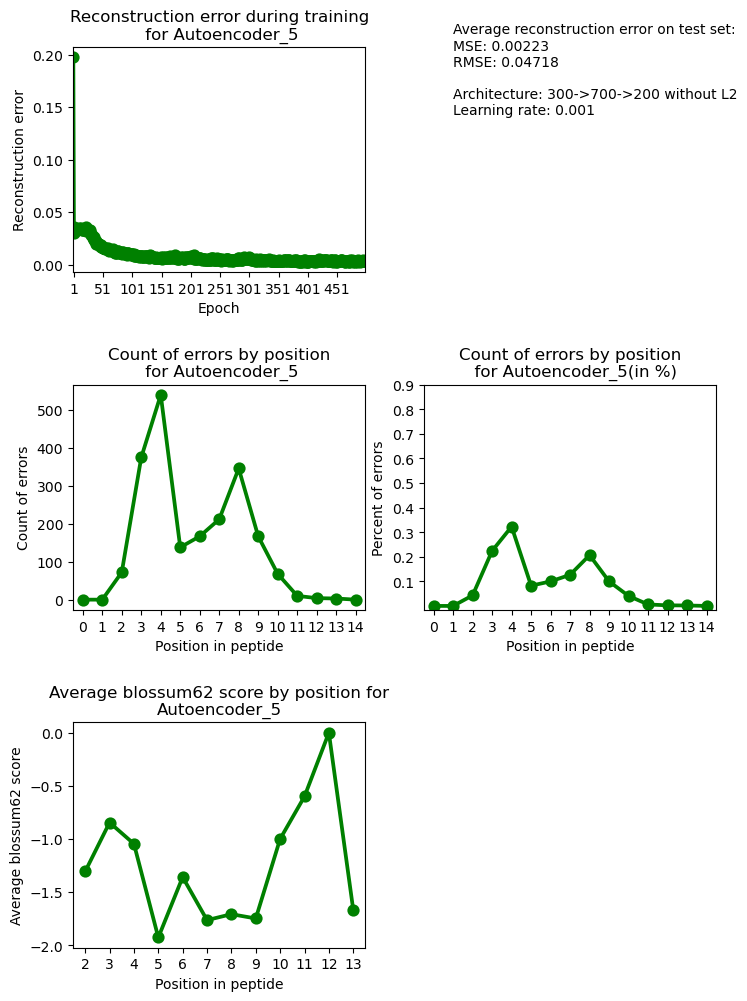

In [32]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_6 definition (300->200->100)

In [33]:
numb += 1
autoencoder_arch = '300->200->100 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 160800


### Train autoencoder

In [34]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.240503
Epoch [11 / 500] average reconstruction error: 0.029937
Epoch [21 / 500] average reconstruction error: 0.028826
Epoch [31 / 500] average reconstruction error: 0.025070
Epoch [41 / 500] average reconstruction error: 0.023105
Epoch [51 / 500] average reconstruction error: 0.021198
Epoch [61 / 500] average reconstruction error: 0.017897
Epoch [71 / 500] average reconstruction error: 0.016508
Epoch [81 / 500] average reconstruction error: 0.014713
Epoch [91 / 500] average reconstruction error: 0.015073
Epoch [101 / 500] average reconstruction error: 0.014484
Epoch [111 / 500] average reconstruction error: 0.012757
Epoch [121 / 500] average reconstruction error: 0.011621
Epoch [131 / 500] average reconstruction error: 0.012798
Epoch [141 / 500] average reconstruction error: 0.011647
Epoch [151 / 500] average reconstruction error: 0.010235
Epoch [161 / 500] average reconstruction error: 0.010841
Epoch [171 / 500] average rec

### Evaluation

In [35]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.003685


### Biological evaluatiuon

In [36]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

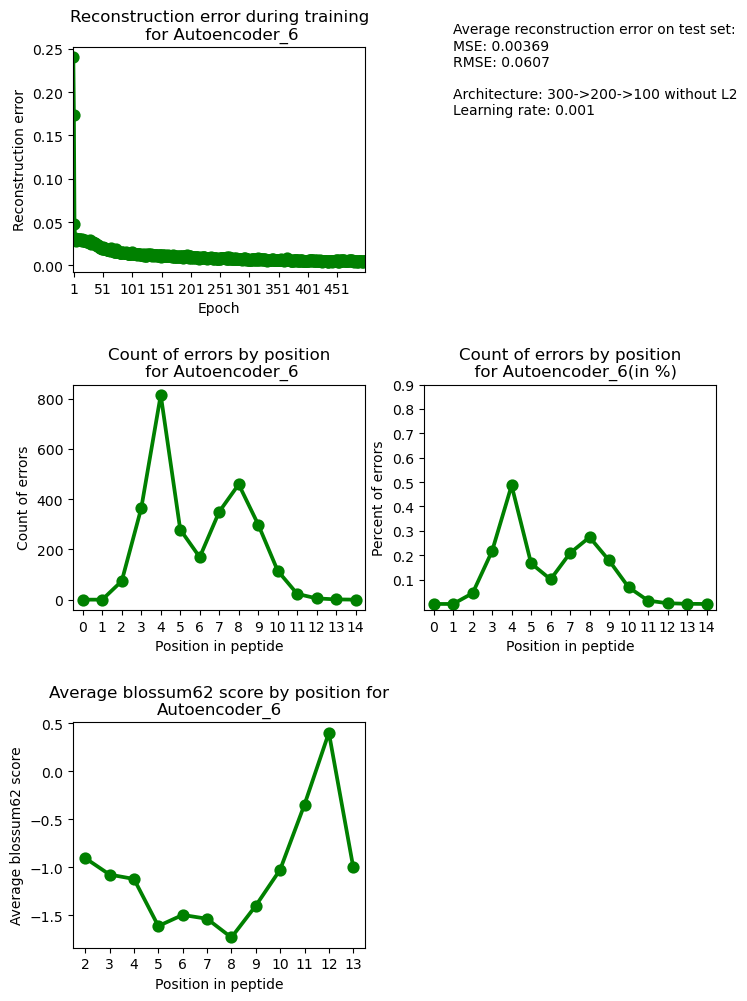

In [37]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_7 definition (300->800->600->200)

In [38]:
numb += 1
autoencoder_arch = '300->800->600->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=800)
        self.fc2 = nn.Linear(in_features=800, out_features=600)
        self.fc3 = nn.Linear(in_features=600, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=800)
        self.fc3 = nn.Linear(in_features=800, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 1683300


### Train autoencoder

In [39]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.181699
Epoch [11 / 500] average reconstruction error: 0.038389
Epoch [21 / 500] average reconstruction error: 0.037437
Epoch [31 / 500] average reconstruction error: 0.038389
Epoch [41 / 500] average reconstruction error: 0.036485
Epoch [51 / 500] average reconstruction error: 0.037437
Epoch [61 / 500] average reconstruction error: 0.038389
Epoch [71 / 500] average reconstruction error: 0.037437
Epoch [81 / 500] average reconstruction error: 0.037437
Epoch [91 / 500] average reconstruction error: 0.037437
Epoch [101 / 500] average reconstruction error: 0.036485
Epoch [111 / 500] average reconstruction error: 0.036485
Epoch [121 / 500] average reconstruction error: 0.037437
Epoch [131 / 500] average reconstruction error: 0.036485
Epoch [141 / 500] average reconstruction error: 0.036485
Epoch [151 / 500] average reconstruction error: 0.036485
Epoch [161 / 500] average reconstruction error: 0.036485
Epoch [171 / 500] average rec

### Evaluation

In [40]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.020661


### Biological evaluatiuon

In [41]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

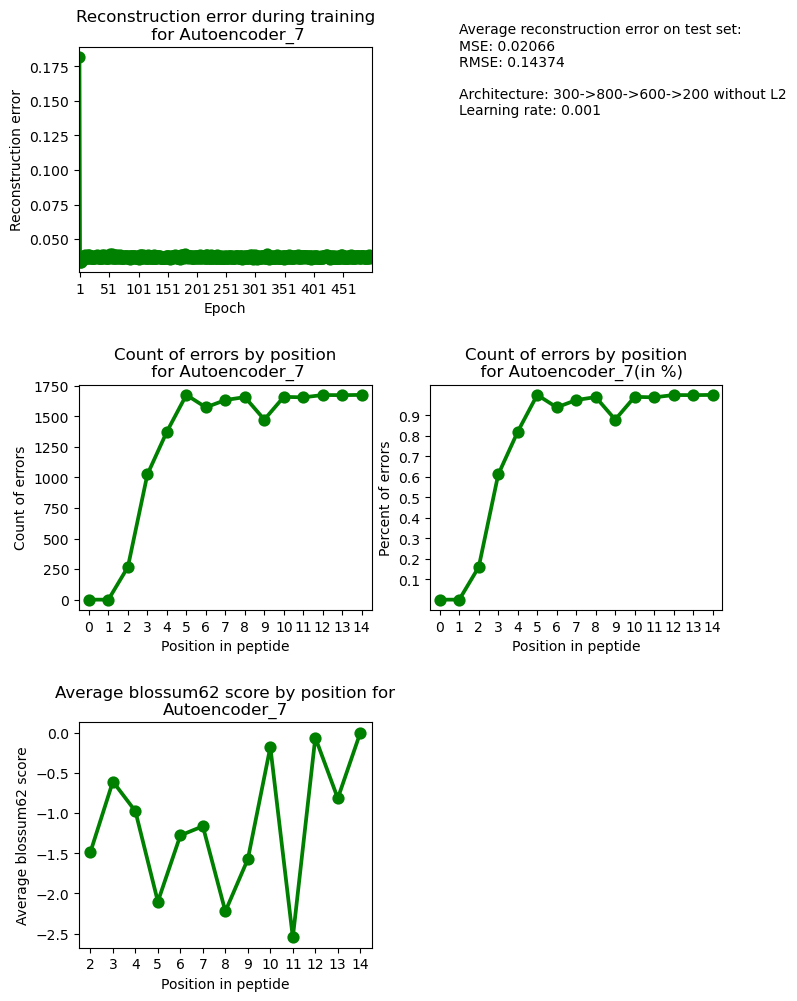

In [42]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_8 definition (300->500D->100)

In [43]:
numb += 1
autoencoder_arch = '300->500D->100 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.2)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 401400


### Train autoencoder

In [44]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.223203
Epoch [11 / 500] average reconstruction error: 0.032407
Epoch [21 / 500] average reconstruction error: 0.027284
Epoch [31 / 500] average reconstruction error: 0.024473
Epoch [41 / 500] average reconstruction error: 0.020645
Epoch [51 / 500] average reconstruction error: 0.018088
Epoch [61 / 500] average reconstruction error: 0.017651
Epoch [71 / 500] average reconstruction error: 0.016511
Epoch [81 / 500] average reconstruction error: 0.014436
Epoch [91 / 500] average reconstruction error: 0.013600
Epoch [101 / 500] average reconstruction error: 0.013902
Epoch [111 / 500] average reconstruction error: 0.014189
Epoch [121 / 500] average reconstruction error: 0.010921
Epoch [131 / 500] average reconstruction error: 0.012530
Epoch [141 / 500] average reconstruction error: 0.011888
Epoch [151 / 500] average reconstruction error: 0.010905
Epoch [161 / 500] average reconstruction error: 0.010198
Epoch [171 / 500] average rec

### Evaluation

In [45]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.002921


### Biological evaluatiuon

In [46]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

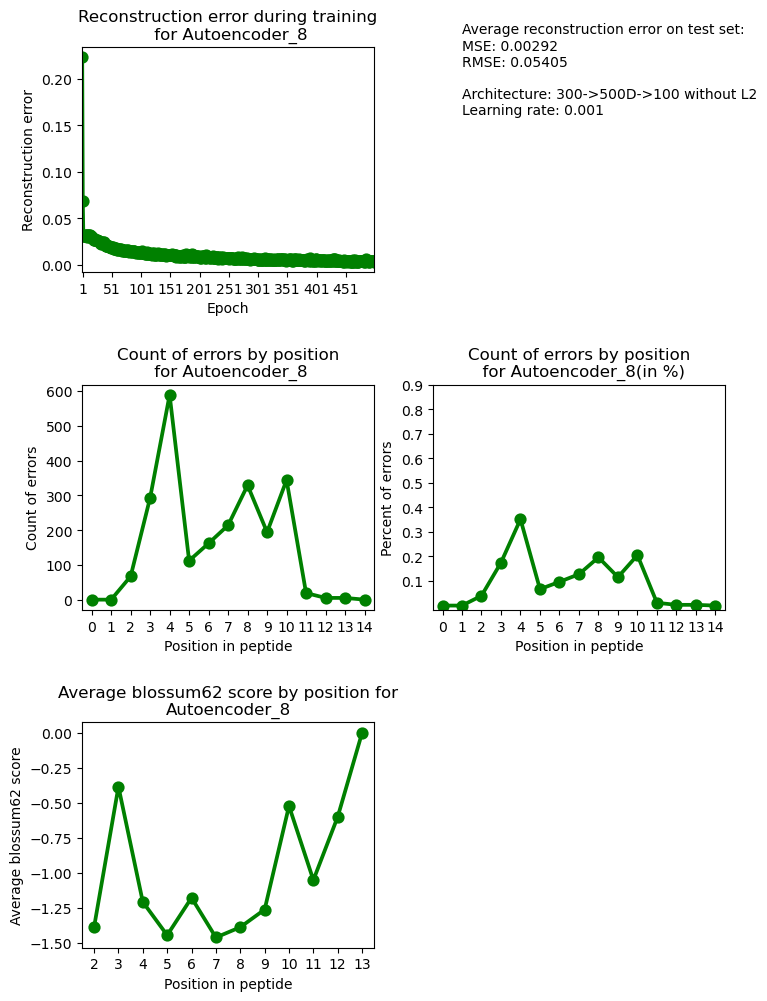

In [47]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_9 definition (300->2000->1000->200)

In [48]:
numb += 1
autoencoder_arch = '300->2000->1000->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=2000)
        self.fc3 = nn.Linear(in_features=2000, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 5606500


### Train autoencoder

In [49]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.119552
Epoch [11 / 500] average reconstruction error: 0.037253
Epoch [21 / 500] average reconstruction error: 0.035349
Epoch [31 / 500] average reconstruction error: 0.035349
Epoch [41 / 500] average reconstruction error: 0.035349
Epoch [51 / 500] average reconstruction error: 0.036301
Epoch [61 / 500] average reconstruction error: 0.036301
Epoch [71 / 500] average reconstruction error: 0.035349
Epoch [81 / 500] average reconstruction error: 0.034398
Epoch [91 / 500] average reconstruction error: 0.038204
Epoch [101 / 500] average reconstruction error: 0.036301
Epoch [111 / 500] average reconstruction error: 0.035349
Epoch [121 / 500] average reconstruction error: 0.038204
Epoch [131 / 500] average reconstruction error: 0.036301
Epoch [141 / 500] average reconstruction error: 0.037253
Epoch [151 / 500] average reconstruction error: 0.038204
Epoch [161 / 500] average reconstruction error: 0.038204
Epoch [171 / 500] average rec

### Evaluation

In [50]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.020287


### Biological evaluatiuon

In [51]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

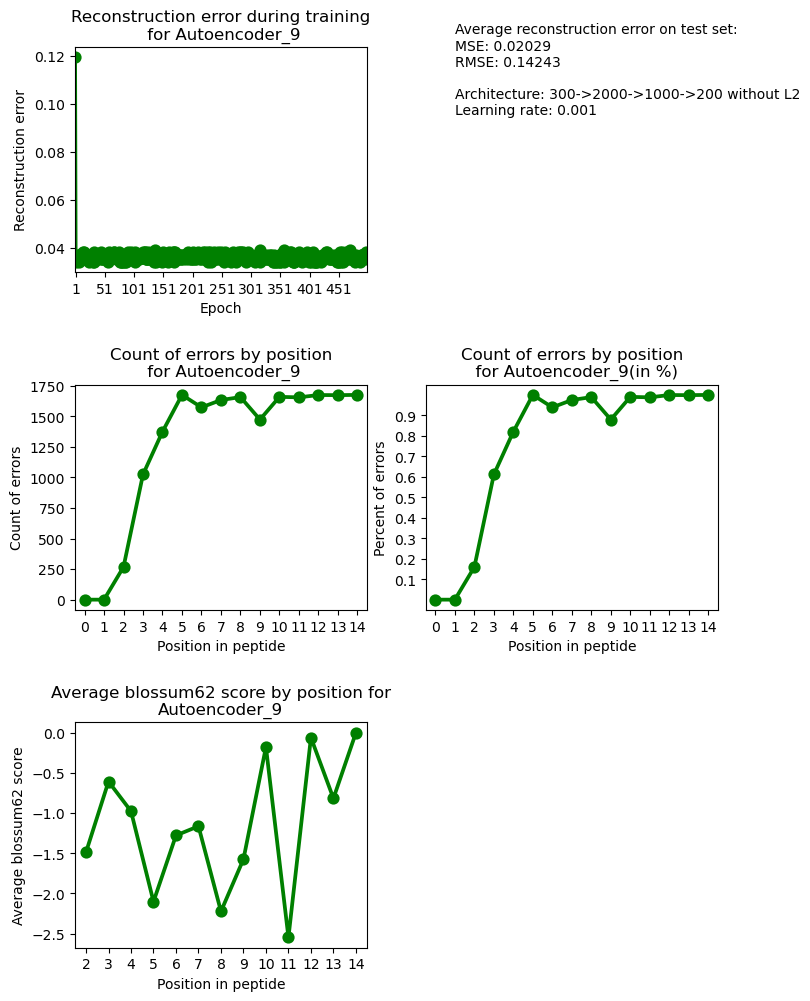

In [52]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_10 definition (300->2000->200)

In [53]:
numb += 1
autoencoder_arch = '300->2000->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 2004500


### Train autoencoder

In [54]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.126859
Epoch [11 / 500] average reconstruction error: 0.034787
Epoch [21 / 500] average reconstruction error: 0.034787
Epoch [31 / 500] average reconstruction error: 0.033835
Epoch [41 / 500] average reconstruction error: 0.036690
Epoch [51 / 500] average reconstruction error: 0.035738
Epoch [61 / 500] average reconstruction error: 0.034787
Epoch [71 / 500] average reconstruction error: 0.035738
Epoch [81 / 500] average reconstruction error: 0.035738
Epoch [91 / 500] average reconstruction error: 0.035738
Epoch [101 / 500] average reconstruction error: 0.034787
Epoch [111 / 500] average reconstruction error: 0.035738
Epoch [121 / 500] average reconstruction error: 0.036690
Epoch [131 / 500] average reconstruction error: 0.036690
Epoch [141 / 500] average reconstruction error: 0.035738
Epoch [151 / 500] average reconstruction error: 0.035738
Epoch [161 / 500] average reconstruction error: 0.035738
Epoch [171 / 500] average rec

### Evaluation

In [55]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.020019


### Biological evaluatiuon

In [56]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

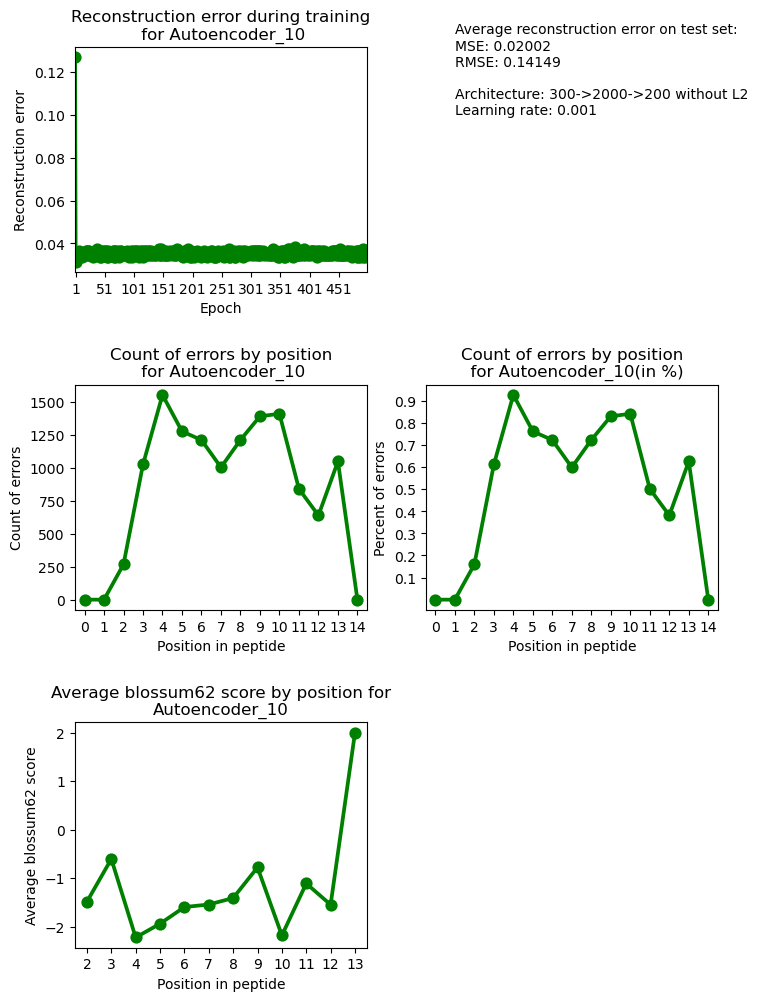

In [57]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_11 definition (300->700->200)

In [58]:
numb += 1
learning_rate = 0.0001
autoencoder_arch = '300->700->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [59]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.248181
Epoch [11 / 500] average reconstruction error: 0.029767
Epoch [21 / 500] average reconstruction error: 0.027777
Epoch [31 / 500] average reconstruction error: 0.027062
Epoch [41 / 500] average reconstruction error: 0.027752
Epoch [51 / 500] average reconstruction error: 0.027021
Epoch [61 / 500] average reconstruction error: 0.027739
Epoch [71 / 500] average reconstruction error: 0.027435
Epoch [81 / 500] average reconstruction error: 0.026360
Epoch [91 / 500] average reconstruction error: 0.025012
Epoch [101 / 500] average reconstruction error: 0.023384
Epoch [111 / 500] average reconstruction error: 0.023147
Epoch [121 / 500] average reconstruction error: 0.021044
Epoch [131 / 500] average reconstruction error: 0.020537
Epoch [141 / 500] average reconstruction error: 0.021311
Epoch [151 / 500] average reconstruction error: 0.020191
Epoch [161 / 500] average reconstruction error: 0.019164
Epoch [171 / 500] average rec

### Evaluation

In [60]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.006145


### Biological evaluatiuon

In [61]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

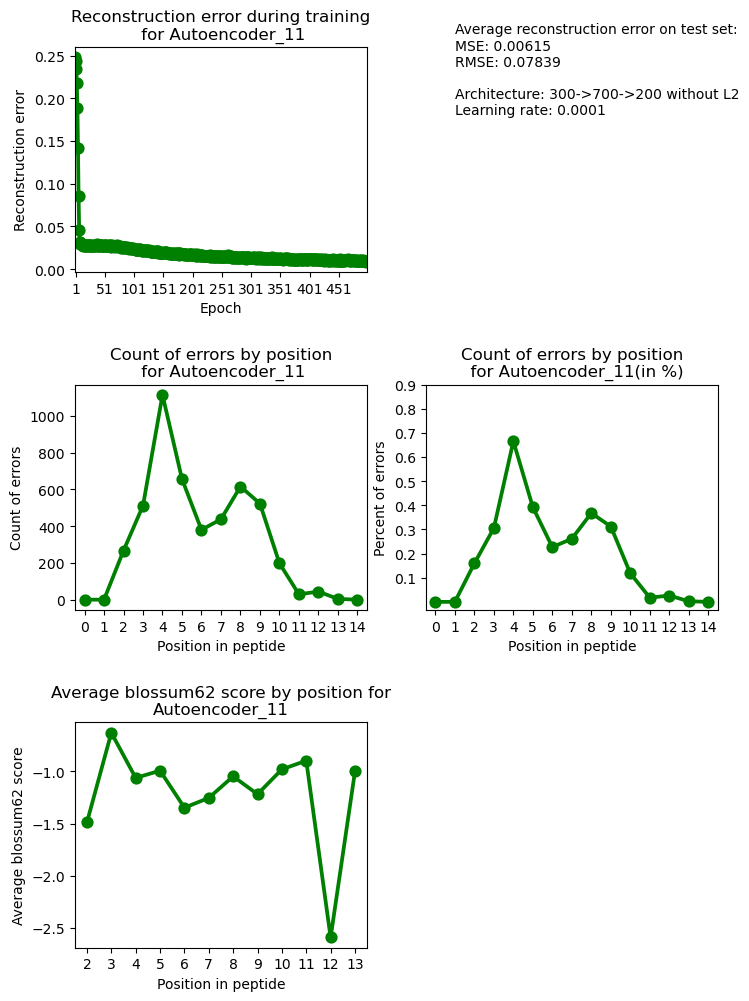

In [62]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_12 definition (300->700->200)

In [63]:
numb += 1
learning_rate = 0.01
autoencoder_arch = '300->700->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [64]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.072678
Epoch [11 / 500] average reconstruction error: 0.039447
Epoch [21 / 500] average reconstruction error: 0.040399
Epoch [31 / 500] average reconstruction error: 0.038495
Epoch [41 / 500] average reconstruction error: 0.038495
Epoch [51 / 500] average reconstruction error: 0.037544
Epoch [61 / 500] average reconstruction error: 0.041350
Epoch [71 / 500] average reconstruction error: 0.039447
Epoch [81 / 500] average reconstruction error: 0.038495
Epoch [91 / 500] average reconstruction error: 0.038495
Epoch [101 / 500] average reconstruction error: 0.040399
Epoch [111 / 500] average reconstruction error: 0.038495
Epoch [121 / 500] average reconstruction error: 0.038495
Epoch [131 / 500] average reconstruction error: 0.040399
Epoch [141 / 500] average reconstruction error: 0.038495
Epoch [151 / 500] average reconstruction error: 0.038495
Epoch [161 / 500] average reconstruction error: 0.039447
Epoch [171 / 500] average rec

### Evaluation

In [65]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.022496


### Biological evaluatiuon

In [66]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

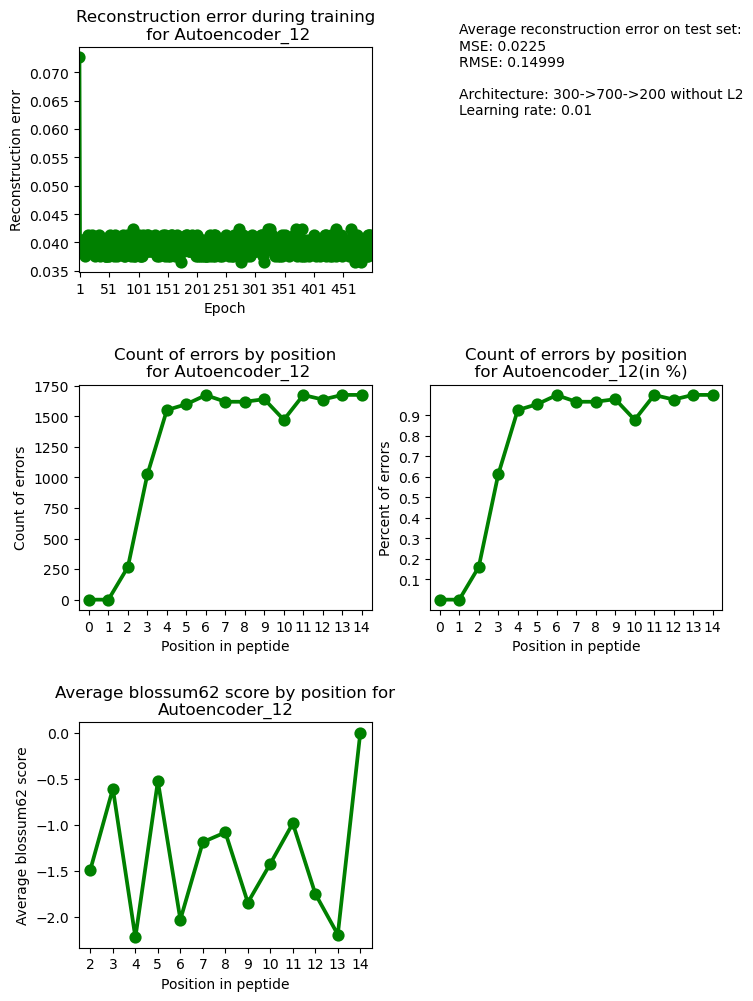

In [67]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_13 definition (300->700->200) without L2

In [68]:
numb += 1
learning_rate = 1e-3
autoencoder_arch = '300->700->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [69]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.197237
Epoch [11 / 500] average reconstruction error: 0.033031
Epoch [21 / 500] average reconstruction error: 0.032059
Epoch [31 / 500] average reconstruction error: 0.031374
Epoch [41 / 500] average reconstruction error: 0.021908
Epoch [51 / 500] average reconstruction error: 0.017466
Epoch [61 / 500] average reconstruction error: 0.015522
Epoch [71 / 500] average reconstruction error: 0.014998
Epoch [81 / 500] average reconstruction error: 0.011519
Epoch [91 / 500] average reconstruction error: 0.010449
Epoch [101 / 500] average reconstruction error: 0.010979
Epoch [111 / 500] average reconstruction error: 0.010468
Epoch [121 / 500] average reconstruction error: 0.007957
Epoch [131 / 500] average reconstruction error: 0.007550
Epoch [141 / 500] average reconstruction error: 0.008584
Epoch [151 / 500] average reconstruction error: 0.008500
Epoch [161 / 500] average reconstruction error: 0.008200
Epoch [171 / 500] average rec

### Evaluation

In [70]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.002002


### Biological evaluatiuon

In [71]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

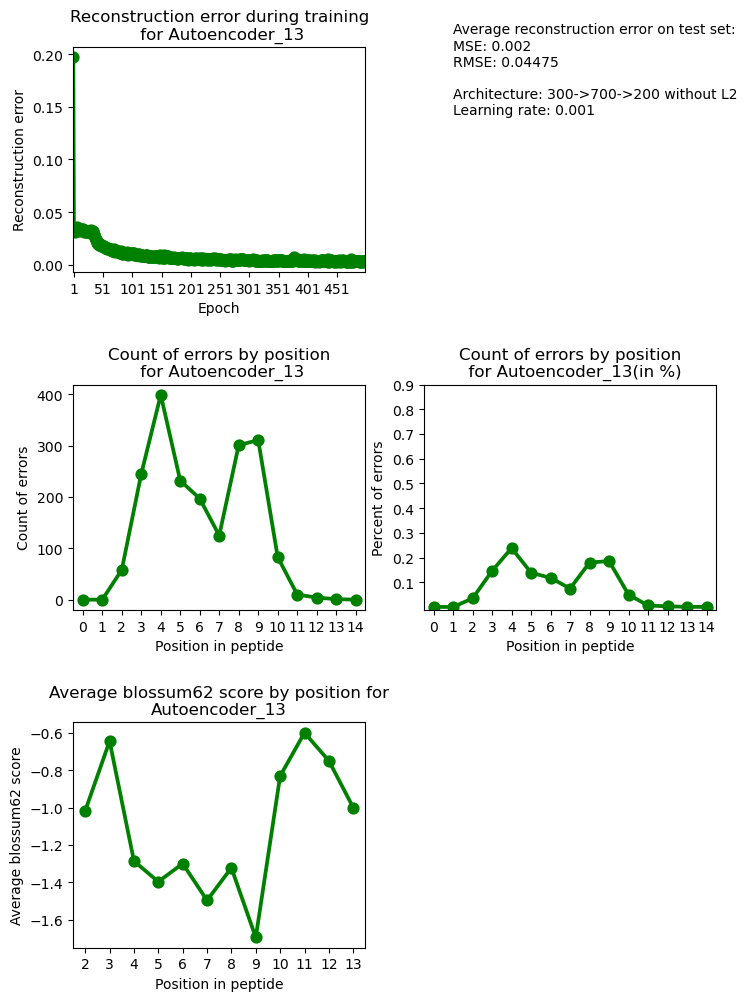

In [72]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_14 definition (300->700->200) with big L2

In [73]:
numb += 1
learning_rate = 1e-3
autoencoder_arch = '300->700->200 with big L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate,  weight_decay = 1e-2)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [74]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 500] average reconstruction error: 0.248630
Epoch [11 / 500] average reconstruction error: 0.032096
Epoch [21 / 500] average reconstruction error: 0.035169
Epoch [31 / 500] average reconstruction error: 0.036304
Epoch [41 / 500] average reconstruction error: 0.036928
Epoch [51 / 500] average reconstruction error: 0.037339
Epoch [61 / 500] average reconstruction error: 0.036453
Epoch [71 / 500] average reconstruction error: 0.036335
Epoch [81 / 500] average reconstruction error: 0.035829
Epoch [91 / 500] average reconstruction error: 0.037162
Epoch [101 / 500] average reconstruction error: 0.036344
Epoch [111 / 500] average reconstruction error: 0.035668
Epoch [121 / 500] average reconstruction error: 0.036162
Epoch [131 / 500] average reconstruction error: 0.035493
Epoch [141 / 500] average reconstruction error: 0.035988
Epoch [151 / 500] average reconstruction error: 0.036588
Epoch [161 / 500] average reconstruction error: 0.035559
Epoch [171 / 500] average rec

### Evaluation

In [75]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.021821


### Biological evaluatiuon

In [76]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

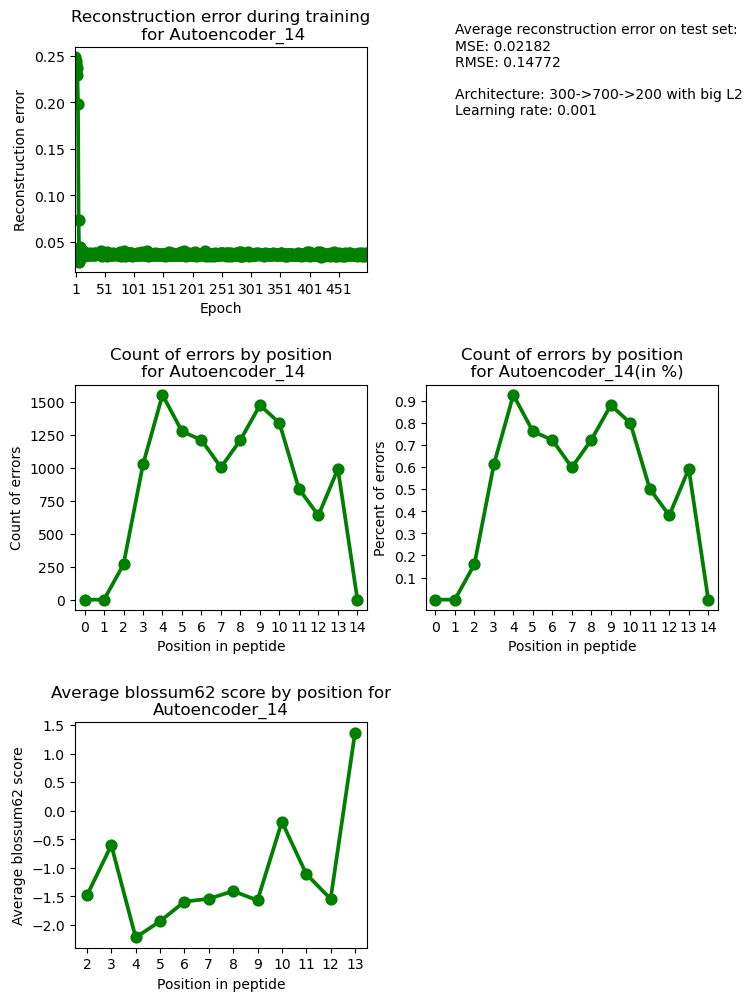

In [77]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')
